# Joint Energy-Based Models (JEM)

## 1. Understanding Energy-Based Models (EBMs)

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random as random
import torchvision
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_shape = (1, 28, 28)
batch_size = 64
num_classes = 10
lr = 1e-4
beta1 = 0.0
alpha = 0.1
epochs = 10

## 2. Designing the JEM Model

In [41]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

class JEMClassifier(nn.Module):
    def __init__(self, hidden_features=32):
        super().__init__()
        c_hid1 = hidden_features // 2
        c_hid2 = hidden_features
        c_hid3 = hidden_features * 2

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4),  # [16x16]
            Swish(),
            nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1),  # [8x8]
            Swish(),
            nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1),  # [4x4]
            Swish(),
            nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1),  # [2x2]
            Swish(),
            nn.Flatten()
        )
        self.fc_energy = nn.Linear(c_hid3 * 4, 1)
        self.fc_class = nn.Linear(c_hid3 * 4, num_classes)

    def forward(self, x):
        features = self.cnn_layers(x)
        energy = self.fc_energy(features).squeeze(-1)
        logits = self.fc_class(features)
        return energy, logits

## 3. Sampling from the Model

In [42]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size # same as the batch size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        generates fake samples using the replay buffer and MCMC
        """
        device = next(self.model.parameters()).device

        ## see on the training algo - 95% of chances to get from the buffer and 5% from random noise
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape, device=device) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0).to(device)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach()

        ## MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        ## update buffer
        self.examples = list(inp_imgs.cpu().chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs


    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        MCMC step
        """
        device = inp_imgs.device
        is_training = model.training
        model.eval()

        #before MCMC: freeze the model
        #we are only interested in the gradients of the input.
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        noise = torch.randn(inp_imgs.shape, device=device)

        imgs_per_step = []

        for _ in range(steps): #the MCMC interation steps
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            out_imgs = -model(inp_imgs)[0] #only modification from the usual EBM sampler
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03)

            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

## 4. Loss Function

In [43]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = JEMClassifier(hidden_features=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
sampler = Sampler(model, img_shape=(1, 28, 28), sample_size=batch_size)


def jem_loss(energy_real, energy_fake, logits, labels, alpha):
    min_batch_size = min(energy_real.size(0), energy_fake.size(0))
    energy_real = energy_real[:min_batch_size]
    energy_fake = energy_fake[:min_batch_size]

    reg_loss = alpha * (energy_real ** 2 + energy_fake ** 2).mean()
    cdiv_loss = energy_fake.mean() - energy_real.mean()

    class_loss = nn.CrossEntropyLoss()(logits, labels)

    total_loss = reg_loss + cdiv_loss + class_loss
    return total_loss, reg_loss, cdiv_loss, class_loss

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 455kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.16MB/s]


## 5. Training Process

In [44]:
for epoch in range(epochs):
    model.train()
    train_loss, reg_loss, cdiv_loss, class_loss = 0, 0, 0, 0

    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs = real_imgs + small_noise
        real_imgs = real_imgs.clamp(min=-1.0, max=1.0)

        fake_imgs = sampler.sample_new_exmps(steps=60, step_size=10)

        energy_real, logits_real = model(real_imgs)
        energy_fake, _ = model(fake_imgs)

        loss, r_loss, c_loss, cls_loss = jem_loss(
            energy_real, energy_fake, logits_real, labels, alpha
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        reg_loss += r_loss.item()
        cdiv_loss += c_loss.item()
        class_loss += cls_loss.item()

    scheduler.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
            _, logits_val = model(val_imgs)
            predictions = torch.argmax(logits_val, dim=1)
            correct += (predictions == val_labels).sum().item()
            total += val_labels.size(0)

    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Reg Loss: {reg_loss / len(train_loader):.4f}, "
          f"CDiv Loss: {cdiv_loss / len(train_loader):.4f}, Class Loss: {class_loss / len(train_loader):.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/10
Train Loss: 1.0443, Reg Loss: 0.0398, CDiv Loss: -0.0429, Class Loss: 1.0474
Validation Accuracy: 0.8575
Epoch 2/10
Train Loss: 0.4401, Reg Loss: 0.0107, CDiv Loss: 0.0242, Class Loss: 0.4052
Validation Accuracy: 0.8962
Epoch 3/10
Train Loss: 0.3441, Reg Loss: 0.0042, CDiv Loss: 0.0306, Class Loss: 0.3093
Validation Accuracy: 0.9174
Epoch 4/10
Train Loss: 0.2806, Reg Loss: 0.0029, CDiv Loss: 0.0271, Class Loss: 0.2507
Validation Accuracy: 0.9347
Epoch 5/10
Train Loss: 0.2295, Reg Loss: 0.0033, CDiv Loss: 0.0211, Class Loss: 0.2050
Validation Accuracy: 0.9472
Epoch 6/10
Train Loss: 0.1903, Reg Loss: 0.0033, CDiv Loss: 0.0165, Class Loss: 0.1705
Validation Accuracy: 0.9555
Epoch 7/10
Train Loss: 0.1640, Reg Loss: 0.0026, CDiv Loss: 0.0158, Class Loss: 0.1456
Validation Accuracy: 0.9645
Epoch 8/10
Train Loss: 0.1449, Reg Loss: 0.0023, CDiv Loss: 0.0161, Class Loss: 0.1265
Validation Accuracy: 0.9652
Epoch 9/10
Train Loss: 0.1296, Reg Loss: 0.0020, CDiv Loss: 0.0151, Class Loss:

## 6. Generating Images

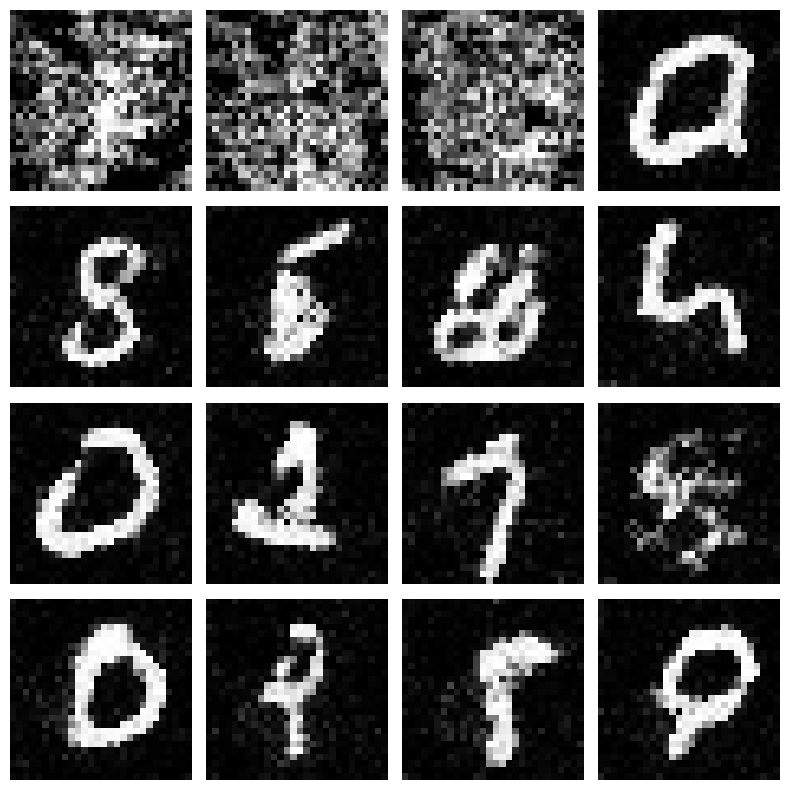

In [45]:
def generate_images_with_sampler(model, sampler, num_images=16, steps=60, step_size=10):
    model.eval()
    with torch.no_grad():
        generated_imgs = sampler.sample_new_exmps(steps=steps, step_size=step_size)
        generated_imgs = generated_imgs[:num_images].detach()

    return generated_imgs.cpu()


def plot_generated_images(images, num_cols=4):
    num_images = images.size(0)
    num_rows = (num_images + num_cols - 1) // num_cols

    images = (images + 1) / 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_images:
            img = images[i].squeeze(0).numpy()
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()


num_images = 16
generated_images = generate_images_with_sampler(model, sampler, num_images=num_images, steps=2000, step_size=0.1)

plot_generated_images(generated_images)